## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import seaborn as sns
import gc
import time
import re
import warnings

warnings.filterwarnings("ignore")

In [2]:
from string import punctuation

In [3]:
# vstack - adds rows, hstack - adds columns
# csr_matrix - used to handle sparse matrix
from scipy.sparse import vstack, hstack, csr_matrix

In [4]:
# CountVectorizer - Simply, counts word frequencies 
# TFIDF - More importance/weights on "rare" words. Less importance/weights on "frequent" words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [5]:
# Logistic Regression - Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc,roc_auc_score

In [6]:

#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
%matplotlib inline

## Reading the data

In [7]:
file = "Consumer_Complaints.csv"
cmplnts = pd.read_csv(file, na_values = "null",encoding = 'utf-8')

In [8]:
# Determining the total size of the dataset
cmplnts.shape

(1241431, 18)

### Splitting data into train and test datasets

In [9]:
train,test = train_test_split(cmplnts, test_size=0.3)
print (train.shape, test.shape)

(869001, 18) (372430, 18)


In [10]:
# Create combined set. You would want to apply count vectorizer on combined set so you can get the list of all possible words.
combined = pd.concat([train,test])

# Create the submission set (Only contains the test ID)
test['test_id']= test.index
submission = test[['test_id']]

# Create size of train
train['train_id']= train.index
train_size = len(train)

In [11]:
combined.shape

(1241431, 18)

In [12]:
combined_ML = combined.sample(frac=0.1).reset_index(drop=True)

In [13]:
combined_ML.shape

(124143, 18)

## Training Set

Training set has 787301 observations with 11 features:



In [14]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1241431 entries, 541769 to 1152039
Data columns (total 18 columns):
Date received                   1241431 non-null object
Product                         1241431 non-null object
Sub-product                     1006265 non-null object
Issue                           1241431 non-null object
Sub-issue                       715688 non-null object
Consumer complaint narrative    374377 non-null object
Company public response         428043 non-null object
Company                         1241431 non-null object
State                           1223587 non-null object
ZIP code                        1132106 non-null object
Tags                            169805 non-null object
Consumer consent provided?      666702 non-null object
Submitted via                   1241431 non-null object
Date sent to company            1241431 non-null object
Company response to consumer    1241425 non-null object
Timely response?                1241431 non-nul

In [15]:
#Addign state codes DC (Washington D.C.), PR (Puerto Rico),{AE,AA,AP} (Armed Forces),VI (Virgin Islands),GU (Guam),FM(Federated States of Micronesia),
# AS (American Samoa),MP (Northern Mariana Islands),MH (Marshall Islands),PW (Palau)

states =['AA','AE','AK','AL','AP','AR','AS','AZ','CA','CO','CT','DC','DE','FL','FM','GA','GU','HI','IA','ID','IL','IN','KS','KY','LA','MA','MD','ME','MI','MN','MO',
         'MP','MH','MS','MT','NC','ND','NE','NH','NJ','NM','NV','NY','OH','OK','OR','PA','PR','PW','RI','SC','SD','TN','TX','UT','VA','VI','VT','WA','WI',
         'WV','WY','UNITED STATES MINOR OUTLYING ISLANDS']

In [16]:
combined.nunique()

Date received                      2665
Product                              18
Sub-product                          76
Issue                               167
Sub-issue                           218
Consumer complaint narrative     358279
Company public response              10
Company                            5234
State                                63
ZIP code                          22380
Tags                                  3
Consumer consent provided?            4
Submitted via                         6
Date sent to company               2614
Company response to consumer          8
Timely response?                      2
Consumer disputed?                    2
Complaint ID                    1241431
dtype: int64

### Summary Statistics

1) There are 8 uniques categories of Company responses.  
2) Most of the complaints were for **Mortgage** and majorly the issue were in **Loan modification,collection and in foreclosure**.  
3) There are **6,800** complaints does not have any Consumer complaint narrative.  
4) Company which got most of the comlaints is **EQUIFAX, INC**.  
5) Most of the complaints were **closed by providing explanations** only.  

In [17]:
combined.astype('object').describe().transpose()

,count,unique,top,freq
Date received,1241431,2665,09/08/2017,3553
Product,1241431,18,Mortgage,274497
Sub-product,1006265,76,Credit reporting,202637
Issue,1241431,167,Incorrect information on your report,122046
Sub-issue,715688,218,Information belongs to someone else,51946
Consumer complaint narrative,374377,358279,There are many mistakes appear in my report wi...,936
Company public response,428043,10,Company has responded to the consumer and the ...,293506
Company,1241431,5234,"EQUIFAX, INC.",110508
State,1223587,63,CA,171133
ZIP code,1132106,22380,300XX,6954


In [18]:
combined.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
541769,01/08/2017,Debt collection,Medical,Cont'd attempts collect debt not owed,Debt was discharged in bankruptcy,AVANTE USA has issue a hard credit on my XXXX ...,NaN,AVANTE,WV,NaN,NaN,Consent provided,Web,01/10/2017,Closed with explanation,Yes,No,2279738
680329,04/23/2016,Credit reporting,NaN,Improper use of my credit report,Report improperly shared by CRC,Equifax improperly shared my credit report and...,NaN,"EQUIFAX, INC.",FL,330XX,NaN,Consent provided,Web,04/23/2016,Closed with explanation,Yes,No,1893699
278731,01/31/2018,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,I have contacted this company a total of 4 tim...,Company has responded to the consumer and the ...,SYNCHRONY FINANCIAL,MD,NaN,NaN,Consent provided,Web,01/31/2018,Closed with non-monetary relief,Yes,NaN,2799707
805938,08/04/2015,Debt collection,Credit card,False statements or representation,Indicated shouldn't respond to lawsuit,"FYI, there not much of a selection for the spe...",Company believes complaint caused principally ...,"Praxis Financial Solutions, Incorporated",CO,802XX,NaN,Consent provided,Web,08/04/2015,Closed with explanation,Yes,No,1500864
725357,01/26/2016,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,NaN,Company chooses not to provide a public response,WELLS FARGO & COMPANY,VA,229XX,NaN,Consent not provided,Web,01/26/2016,Closed with explanation,Yes,No,1755676


In [19]:
combined['Product'] = combined['Product'].astype('category')
combined['Sub-product'] = combined['Sub-product'].astype('category')
combined['Issue'] = combined['Issue'].astype('category')
combined['Sub-issue'] = combined['Sub-issue'].astype('category')
combined['Company public response'] = combined['Company public response'].astype('category')
combined['Consumer consent provided?'] = combined['Consumer consent provided?'].astype('category')
combined['Timely response?'] = combined['Timely response?'].astype('category')
combined['Consumer disputed?'] = combined['Consumer disputed?'].astype('category')
combined['Company response to consumer'] = combined['Company response to consumer'].astype('category')

In [20]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1241431 entries, 541769 to 1152039
Data columns (total 18 columns):
Date received                   1241431 non-null object
Product                         1241431 non-null category
Sub-product                     1006265 non-null category
Issue                           1241431 non-null category
Sub-issue                       715688 non-null category
Consumer complaint narrative    374377 non-null object
Company public response         428043 non-null category
Company                         1241431 non-null object
State                           1223587 non-null object
ZIP code                        1132106 non-null object
Tags                            169805 non-null object
Consumer consent provided?      666702 non-null category
Submitted via                   1241431 non-null object
Date sent to company            1241431 non-null object
Company response to consumer    1241425 non-null category
Timely response?                1

### Data Cleaning

As we can see that there are around 56070.6 millions of rows have no description.  
16 millions of rows does not have sub-product linked to it.  
Sub- Issue andComapny public responses are also missing.  

Filling all those values with the some values and find out the major categories.


In [21]:
combined.shape

(1241431, 18)

In [22]:
def missing_values(df):
    df['Consumer complaint narrative'].fillna(value = 'Other',inplace =True)
    df['Sub-product'].fillna(value = 'Other',inplace =True)
    df['Sub-issue'].fillna(value = 'Other',inplace =True)
    df['Company public response'].fillna(value = 'Other',inplace =True)

    return df

In [23]:
combined['Sub-product']  =  combined['Sub-product'] .cat.add_categories(['Other'])
combined['Sub-issue'] = combined['Sub-issue'].cat.add_categories(['Other'])
combined['Company public response'] = combined['Company public response'].cat.add_categories(['Other'])


In [24]:
combined.shape

(1241431, 18)

In [25]:
combined  = missing_values(combined)

In [26]:
#combined.isnull().sum()

As we can see all the NULL values have been removed formt he important features and the ones which are left can be drop or can be used later in while providing recommendation in final output.

### Exploratory Data Analysis  

We will look after the Categories field.

In [27]:
#combined["Company response to consumer"].describe()

In [28]:
#dict( enumerate(combined["Company response to consumer"].cat.categories) ) 

In [29]:
#combined["Company response to consumer"].value_counts()

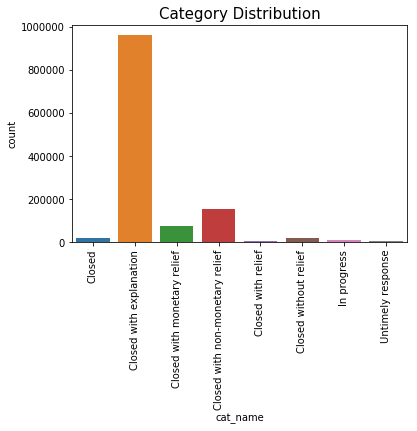

In [30]:
cat = combined["Company response to consumer"].value_counts().reset_index().rename(columns={'index': 'cat_name', 'Company response to consumer':'count'})
ax = sns.barplot(x="cat_name", y="count" ,data=cat)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Category Distribution', fontsize=15)
   
plt.show()

As you can see from the above plot bar that most of the consumer complaints falls into **'Closed with expalnation'** category, after that **'Closed with  non-monetary relief'** then **'Closed with monetary relief'**

## Preparing the corpus for Analysis  

a. Remove Puncuations

b. Remove Digits

c. Remove stop words

d. Lower case words

e. Lemmatization or Stemming

### Removing Punctuation

In [31]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [32]:
#Replacing punctuations

punctuation_symbols =[]

for p in punctuation:
    punctuation_symbols.append((p,''))

punctuation_symbols

[('!', ''),
 ('"', ''),
 ('#', ''),
 ('$', ''),
 ('%', ''),
 ('&', ''),
 ("'", ''),
 ('(', ''),
 (')', ''),
 ('*', ''),
 ('+', ''),
 (',', ''),
 ('-', ''),
 ('.', ''),
 ('/', ''),
 (':', ''),
 (';', ''),
 ('<', ''),
 ('=', ''),
 ('>', ''),
 ('?', ''),
 ('@', ''),
 ('[', ''),
 ('\\', ''),
 (']', ''),
 ('^', ''),
 ('_', ''),
 ('`', ''),
 ('{', ''),
 ('|', ''),
 ('}', ''),
 ('~', '')]

In [33]:
import string
def remove_punctuation(sentence: str) -> str:
    return sentence.translate(str.maketrans('', '', string.punctuation))

### Removing Digits

In [34]:
def remove_digit(s):
    s = ''.join([k for k in s if not k.isdigit()])
    return s

### Remove Stop Words

In [35]:
from nltk.corpus import stopwords

stop = stopwords.words('english')

def remove_stop_words(x):
    x = ' '.join([i for i in x.lower().split(' ') if i not in stop])
    return x

### Lowercase Words

In [36]:
def to_lower(x):
    return x.lower()

### Product Distribution

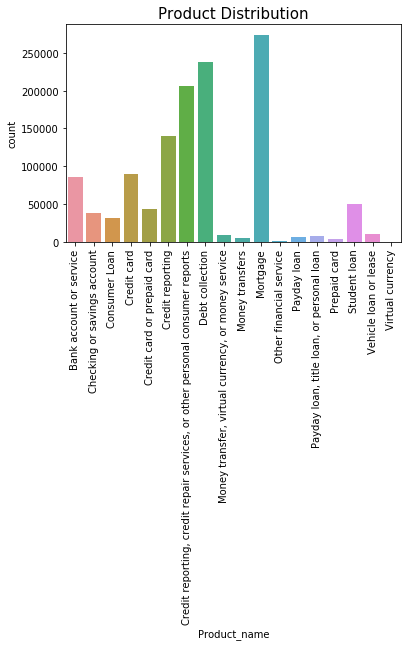

In [37]:
cat = combined["Product"].value_counts().reset_index().rename(columns={'index': 'Product_name', 'Product':'count'})
ax = sns.barplot(x="Product_name", y="count", data=cat)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Product Distribution', fontsize=15)
plt.show()

### Issue Distribution

From the below plot we got to know top 10 issues in th dataset.

,Issue,Complaint ID
0,Incorrect information on your report,122046
1,"Loan modification,collection,foreclosure",112311
2,Incorrect information on credit report,102686
3,"Loan servicing, payments, escrow account",77333
4,Cont'd attempts collect debt not owed,60691
5,Problem with a credit reporting company's inve...,46688
6,Attempts to collect debt not owed,39524
7,"Account opening, closing, or management",37961
8,Communication tactics,34612
9,Improper use of your report,31521


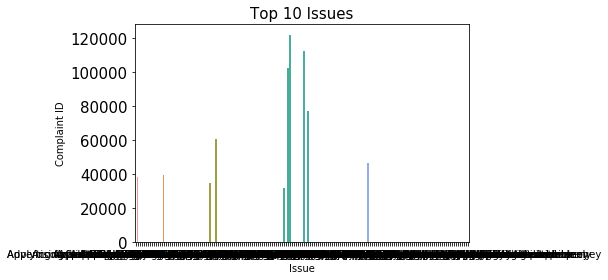

In [38]:
# Display Top 20 Issues By their Categories
top10_issue = combined.groupby('Issue', axis=0).count()

df_ID = pd.DataFrame(top10_issue.sort_values('Complaint ID', ascending = False)['Complaint ID'][0:10].reset_index())
ax = sns.barplot(df_ID.Issue, df_ID["Complaint ID"], data=df_ID)
#ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize=15)
#ax.set_xticklabels(df_ID.Issue,rotation=60)
ax.set_title('Top 10 Issues', fontsize=15)
#plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
df_ID
#plt.show()# Displayd frequency ratio of brand names

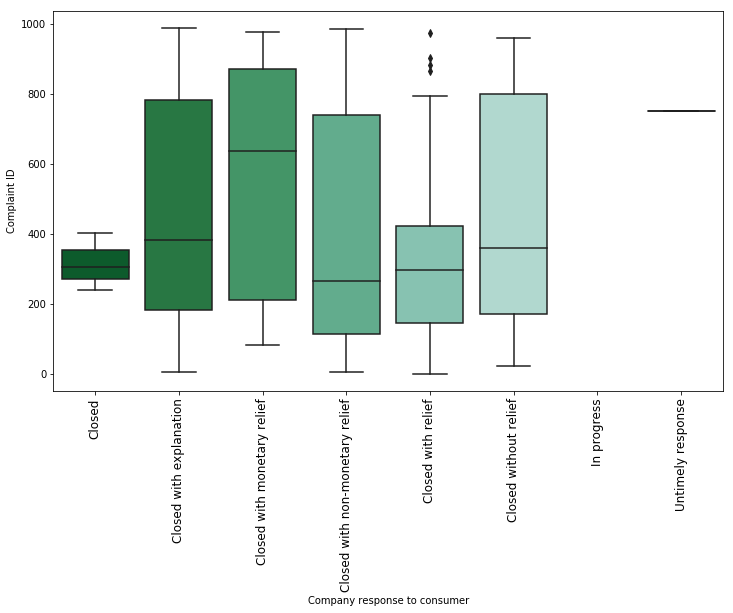

In [39]:
fig, axes = plt.subplots(figsize=(12, 7))
main = combined[combined["Complaint ID"]<1000]
# Use a color palette
ax = sns.boxplot( x=main["Company response to consumer"], y=main["Complaint ID"], palette="BuGn_r")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize=12)

plt.show()

## Consumer Narrative Analysis

Hypothesis:

Does length play a role in final result?  
Does certain descriptions gives a same result?  
Lenghthier descriptions mean more effort in the process, more authentic, more valuable?  

In [40]:

combined["Consumer complaint narrative"] = combined["Consumer complaint narrative"].astype(str)

In [41]:
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()

combined["Consumer complaint narrative"] = combined["Consumer complaint narrative"].apply(porter.stem)

In [42]:
# to_categorical - Converts Categorical Features 
def to_categorical(df):
    df['Product'] = df['Product'].astype('category')
    df['Sub-product'] = df['Sub-product'].astype('category')
    df['Issue'] = df['Issue'].astype('category')
    df['Sub-issue'] = df['Sub-issue'].astype('category')
    df['Company public response'] = df['Company public response'].astype('category')
    df['Consumer consent provided?'] = df['Consumer consent provided?'].astype('category')
    df['Company response to consumer'] = df['Company response to consumer'].astype('category')
    df['Company response to consumer cat'] =  df['Company response to consumer'].cat.codes
    #df['Sub-product']  =  df['Sub-product'] .cat.add_categories(['Other'])
    #df['Sub-issue'] = df['Sub-issue'].cat.add_categories(['Other'])
    #df['Company public response'] = df['Company public response'].cat.add_categories(['None'])

## Applying Preprocessing Functions

In [43]:
to_categorical(combined)

In [44]:
# Remove Punctuation
combined["Consumer complaint narrative"] = combined["Consumer complaint narrative"].astype(str)

combined["Consumer complaint narrative"] = combined["Consumer complaint narrative"].apply(remove_digit)
combined["Consumer complaint narrative"] = combined["Consumer complaint narrative"].apply(remove_punctuation)

combined["Consumer complaint narrative"] = combined["Consumer complaint narrative"].apply(remove_stop_words)
#train["Consumer complaint narrative"] = train["Consumer complaint narrative"].replace(['x','X'],'')
combined["Product"] = combined["Product"].apply(remove_digit)
combined["Product"] = combined["Product"].apply(remove_punctuation)
combined["Product"] = combined["Product"].apply(remove_stop_words)

combined["Issue"] = combined["Issue"].apply(remove_digit)
combined["Issue"] = combined["Issue"].apply(remove_punctuation)
combined["Issue"] = combined["Issue"].apply(remove_stop_words)


In [45]:
combined.shape

(1241431, 19)

### Feature Extraction with text

**Feature Pre-Processing**: Sometimes you can't just fit a dataset into your model and expect good results. Each type of feature has their own way of preprocessing. Choice of preprocessing method also depends on the model we are trying to use.

Since we're working with Text Features, we're going to do a lot of vectorization:

**Tokenization**: split each text into words (bag of words model)  
**Stemming**: removing word inflections (getting the root word)  
**Vectorization**: reducing text into a vector with different types of frequencies for each word (Count Values or TF-IDF Values)

### Bag Of Words

When we vectorize these words, we're doing creating a feature for each word. Also known as, Bag of Words. We lose word ordering

**Solution:** To preserve some ordering, we can introduce n-grams into our vectorization of words (problem: too many features)

one way to reduce dimensions of n-grams is to remove stop words (a, the, is)
**stop words:** we can remove these words becaues they are just there for grammatical structure with little to no meaning
**n-gram**\   with smaller frequencies can highlight and capture important parts of a document/text. This preserves local ordering and can improve model performance.

In [46]:
# Examine the normalize item description
combined =combined[combined['Consumer complaint narrative'] != '']

In [47]:
def dup_char(x):
    return (re.sub('[xx]','',x))

In [48]:
combined["Consumer complaint narrative"] = combined["Consumer complaint narrative"].astype(str).apply(dup_char)

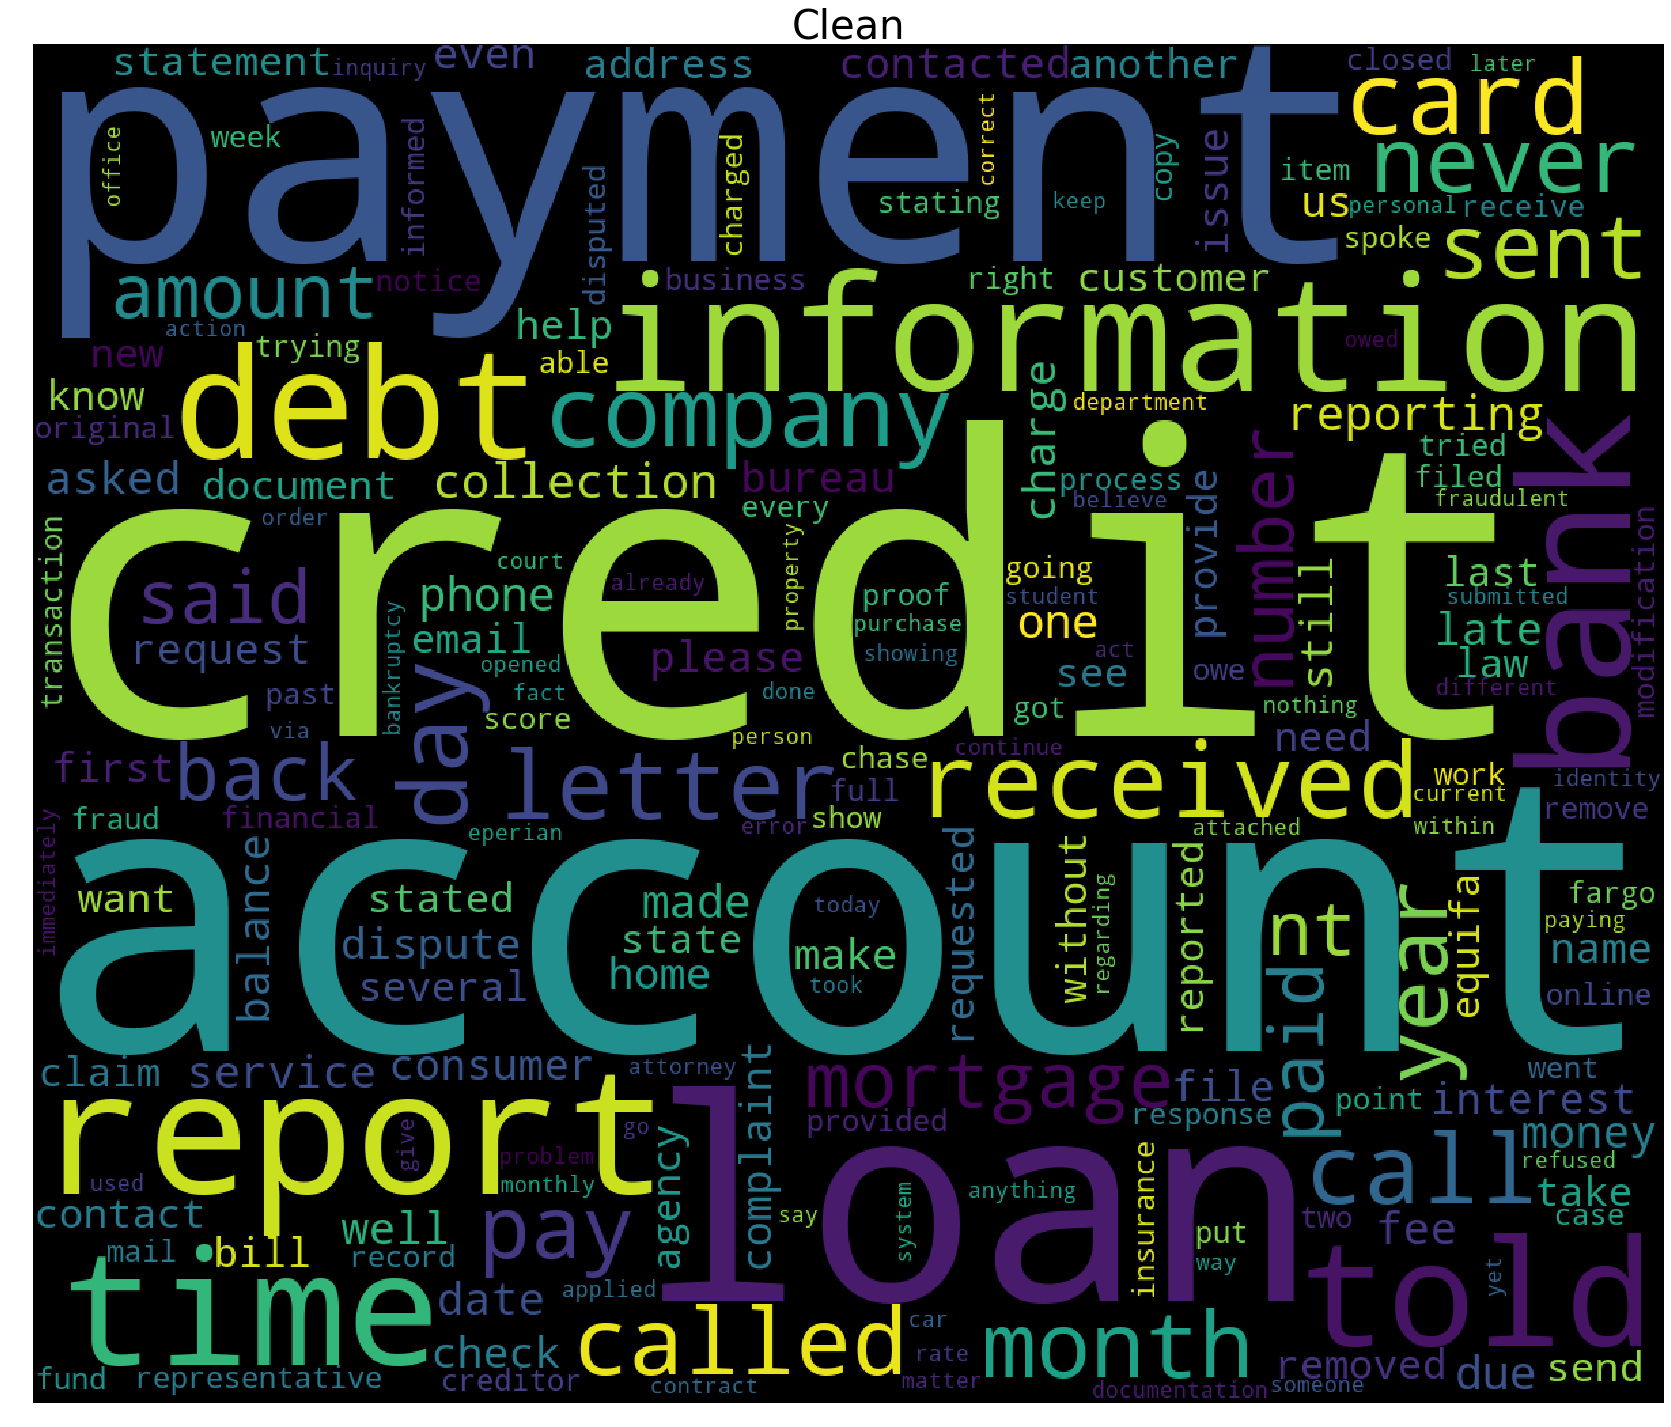

In [49]:

from wordcloud import WordCloud,STOPWORDS

plt.figure(figsize=(40,25))
# clean
subset = combined[combined['Consumer complaint narrative'] != '']
text = subset['Consumer complaint narrative'].values
cloud_toxic = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=1200,
                          height=1000
                         ).generate(" ".join(text))
plt.axis('off')
plt.title("Clean",fontsize=40)
plt.imshow(cloud_toxic)


In [50]:
# Examine the normalize item description
combined['Consumer complaint narrative'][60:70]

210441    received letter mail stating account closed du...
857726    recieved call associate identified   state col...
289024    made repeated phone calls huntington set payme...
704819              fl      account removed credit repor...
431759    wells fargo contacted phon e  times past  week...
578226    paid capital one credit card  inactive since c...
531966     received call navient returned following day ...
349863      asked verification origin debt according fcr...
132444    kidding one report three reports  credit histo...
233214    communicated via certified letter      request...
Name: Consumer complaint narrative, dtype: object

In [51]:
def add_label(x):
    if x in ['Closed with non-monetary relief','Closed with monetary relief']:
        return 1
    else:
        return 0

In [52]:
combined["label"] = combined["Company response to consumer"].apply(add_label)

In [53]:
combined["Company response to consumer"].value_counts()

Closed with explanation            302344
Closed with non-monetary relief     44445
Closed with monetary relief         21300
Closed                               3741
Untimely response                    2542
In progress                             0
Closed without relief                   0
Closed with relief                      0
Name: Company response to consumer, dtype: int64

In [54]:
combined["label"].value_counts()#374376

0    308631
1     65745
Name: label, dtype: int64

In [55]:
#import nltk
#nltk.download('punkt')
from nltk.tokenize import word_tokenize

text1 = combined['Consumer complaint narrative'].iloc[65]
tokens = word_tokenize(text1)


## TF - IDF

Main Goal - Measure how important a word or phrase is within a collection of documents. Its essentially **weigh down** terms that appear frequently and **scale up** unique terms.

** TF Term Frequency-** ( Number of times terms t appears in a document / Total number of terms in the document)  
** IDF Inverse Document Frequency-** log_e( Total number of documents / Number of documents with term t in it)  
** TF X IDF-** A measure of how important term in a document.  

* When you have a **high** term frequency in a document and it appears in many documents in the corpus = ** Low TFIDF**  
* When you have a **low** term frequency in a document and it appears in **not so many** documents in the corpus = ** High TFIDF**  

**CORPUS =  Collection of documents**  

** Important Parameters**  

1. ngram_range  
2. stop words  
3. lowercase  
4. max_df  :-  max threshold that will ignore a term that has a document frequency higher than that.    
5. min_df  :-  min threshold that will ignore a term that has a document frequency lower than that.  
6. max_features :- get the assigned amount of features with highest amount of term frequencies(scores).  



### Count Vectorizer

Generating new features of **Product Name** and **Issue**

In [56]:
X_dummies = pd.get_dummies(combined[['Product', 'Issue']], sparse=True).values

In [57]:
X_dummies_pd = pd.get_dummies(combined[['Product', 'Issue']], sparse=True)

In [58]:
# Apply TFIDF to "Consumer complaint Narrative", min_df=0.03, max_df=1.0
tv = TfidfVectorizer(min_df=0.03, max_df=1.0, ngram_range=(1, 2), stop_words='english',norm ='l1')
X_description = tv.fit_transform(combined['Consumer complaint narrative'])

print(str(X_description.shape))

(374376, 405)


In [59]:
df = pd.DataFrame(X_description.toarray(), columns=tv.get_feature_names())

df.shape

(374376, 405)

#### Observing TF-IDF weights

In [60]:

#  create a dictionary mapping the tokens to their tfidf values
tfidf = dict(zip(tv.get_feature_names(), tv.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict( dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

# Lowest TFIDF Scores
tfidf.sort_values(by=['tfidf'], ascending=True).head(5)

,tfidf
credit,1.605938
account,1.835878
report,2.101480
information,2.232421
received,2.246016


In [61]:
# HIghest TFIDF Scores
tfidf.sort_values(by=['tfidf'], ascending=False).head(5)

,tfidf
thought,4.499488
caused,4.498339
bank account,4.491124
accurate,4.490510
allow,4.488934


In [62]:
print(len(tv.get_feature_names()))

405


In [63]:
# Combine everything together
sparse_merge = hstack((X_description, X_dummies))

In [64]:
#X_train,X_test,y_train,y_test=train_test_split(sparse_merge,combined['Company response to consumer cat'],test_size=0.25,random_state=0)
#print (X_train.shape, y_train.shape)

In [65]:
# X_train,X_test=train_test_split(X_description,test_size=0.25,random_state=0)
# print (X_train.shape, X_test.shape)(1241431, 63)

In [66]:
df['label'] = combined['label'].values

In [67]:
X_train,X_test,Y_train,Y_test=train_test_split(df.iloc[:,df.columns != "label"],df['label'],stratify=df['label'],test_size=0.30,random_state=0)
print (X_train.shape, X_test.shape,Y_train.shape,Y_test.shape)

(262063, 405) (112313, 405) (262063,) (112313,)


In [68]:
Y_train.value_counts()

0    216042
1     46021
Name: label, dtype: int64

In [69]:
# y=pd.get_dummies(combined['label'], prefix="Category")
# Y_train,Y_test=train_test_split(y,test_size=0.25,random_state=0)
# print (Y_train.shape, Y_test.shape)

In [70]:
Y_test.value_counts()

0    92589
1    19724
Name: label, dtype: int64

#### Selecting only top 4 class label which have relevant data to build a model for rest of the classes  there is not data in to keep in the model.

In [71]:
target_cols = ['Category_Closed','Category_Closed with explanation','Category_Closed with monetary relief','Category_Closed with non-monetary relief']
target_cols

['Category_Closed',
 'Category_Closed with explanation',
 'Category_Closed with monetary relief',
 'Category_Closed with non-monetary relief']

### Logistic Regression  Model

In [72]:
"""
prd = np.zeros((X_test.shape[0],y.shape[1]))
cv_score =[]
for i,col in enumerate(target_cols):
    lr = LogisticRegression(C=2,random_state = i,class_weight = 'balanced')
    print('Building {} model for column:{''}'.format(i,col)) 
    lr.fit(X_description,y[col])
    #cv_score.append(lr.score)
    prd[:,i] = lr.predict_proba(X_test)[:,1]
"""

"\nprd = np.zeros((X_test.shape[0],y.shape[1]))\ncv_score =[]\nfor i,col in enumerate(target_cols):\n    lr = LogisticRegression(C=2,random_state = i,class_weight = 'balanced')\n    print('Building {} model for column:{''}'.format(i,col)) \n    lr.fit(X_description,y[col])\n    #cv_score.append(lr.score)\n    prd[:,i] = lr.predict_proba(X_test)[:,1]\n"

In [73]:
class_weights = {1:len(Y_train)/(1*np.sum(Y_train)), 0:len(Y_train)/(len(Y_train)-1*np.sum(Y_train))}

In [74]:
#d = np.zeros((X_test.shape[0],y.shape[1]))
cv_score =[]

lr = LogisticRegression(C=10,random_state=2111, penalty="l1",class_weight = class_weights)
#print('Building {} model for column:{''}'.format(i,col)) 
lr.fit(X_train,Y_train)
#cv_score.append(lr.score)
#prd[:,i] = lr.predict_proba(X_test)[:,1]

LogisticRegression(C=10,
          class_weight={1: 5.694422111644684, 0: 1.2130187648697939},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
          random_state=2111, solver='warn', tol=0.0001, verbose=0,
          warm_start=False)

In [75]:

#preds = prd[:,1]
pred =  lr.predict(X_test)
#fpr, tpr, threshold = roc_curve(Y_test[col], pred)
fpr, tpr, threshold = roc_curve(Y_test, pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.6371802399427318


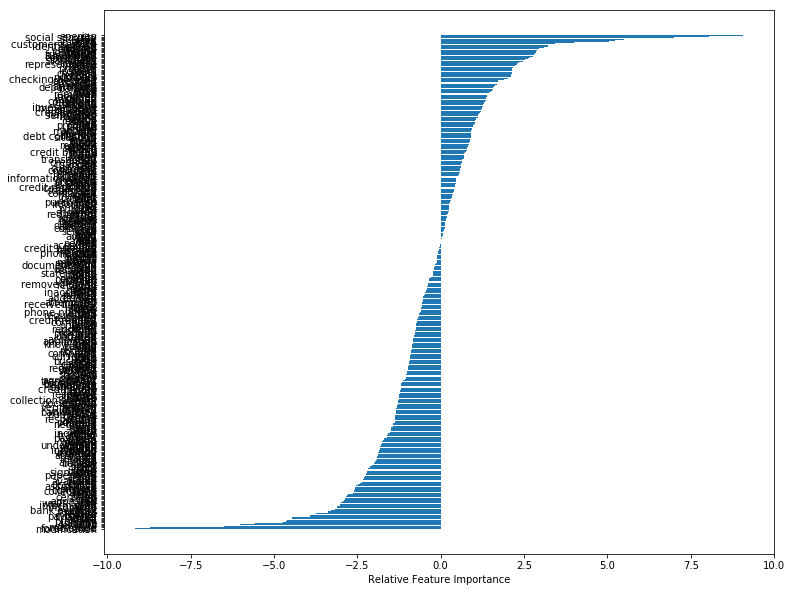

In [76]:
feature_importance = (lr.coef_[0])

#feature_importance = 2 * (feature_importance/max(feature_importance))
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0])

#print(feature_importance)
#print(feature_importance[sorted_idx])
featfig = plt.figure(figsize=(12, 10))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(df.columns)[sorted_idx], fontsize=10)
featax.set_xlabel('Relative Feature Importance')

plt.show()

In [77]:
from xgboost import XGBClassifier

sel_feature = list(sorted_idx[:100]) + list(sorted_idx[-100:])
print(sel_feature)

str_feature =list(df.columns[sel_feature])
#[35 30 43 23  8 29 45  7 24 54] [20 25 17 13 56 16  3  4 27  6]

[216, 147, 221, 323, 203, 174, 204, 274, 128, 90, 145, 254, 196, 280, 315, 329, 38, 386, 182, 338, 176, 396, 193, 25, 194, 279, 57, 58, 336, 195, 314, 75, 78, 275, 165, 29, 239, 268, 40, 34, 200, 339, 208, 7, 249, 324, 18, 333, 376, 133, 229, 6, 247, 51, 41, 19, 368, 404, 290, 375, 346, 33, 219, 388, 343, 173, 212, 181, 401, 378, 230, 255, 390, 28, 160, 253, 131, 371, 76, 179, 109, 106, 320, 155, 326, 319, 226, 134, 267, 21, 308, 50, 130, 113, 236, 262, 39, 383, 238, 14, 206, 367, 202, 359, 92, 166, 340, 334, 311, 377, 301, 149, 151, 365, 68, 46, 335, 110, 118, 111, 42, 213, 23, 54, 105, 259, 271, 47, 107, 305, 358, 53, 48, 220, 327, 158, 322, 96, 49, 127, 170, 183, 37, 321, 299, 284, 86, 306, 256, 231, 172, 293, 209, 108, 129, 88, 36, 114, 30, 394, 184, 70, 13, 65, 66, 235, 164, 281, 125, 62, 89, 393, 237, 272, 266, 187, 300, 243, 148, 344, 144, 277, 81, 352, 150, 241, 146, 61, 11, 63, 288, 168, 104, 52, 20, 135, 140, 138, 337, 126]


In [78]:

xgb1 = XGBClassifier(n_estimators= 400)
xgb1.fit(pd.DataFrame(X_train[str_feature]), Y_train)

ypred = xgb1.predict(pd.DataFrame(X_test[str_feature]))

In [79]:
print(roc_auc_score(Y_test, ypred))
print(classification_report(Y_test, ypred))
print(confusion_matrix(Y_test, ypred))

0.5230950011255894
              precision    recall  f1-score   support

           0       0.83      0.99      0.90     92589
           1       0.58      0.05      0.10     19724

   micro avg       0.83      0.83      0.83    112313
   macro avg       0.71      0.52      0.50    112313
weighted avg       0.79      0.83      0.76    112313

[[91810   779]
 [18647  1077]]


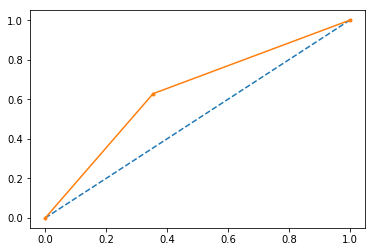

In [80]:
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

Column: Category_Closed with monetary relief

Confusion matrix

[[59788 32801]
 [ 7325 12399]]


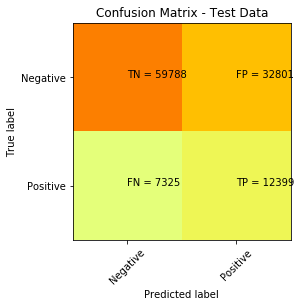

              precision    recall  f1-score   support

           0       0.89      0.65      0.75     92589
           1       0.27      0.63      0.38     19724

   micro avg       0.64      0.64      0.64    112313
   macro avg       0.58      0.64      0.57    112313
weighted avg       0.78      0.64      0.68    112313



In [81]:

col = 'Category_Closed with monetary relief'
print("Column:",col)

print('\nConfusion matrix\n')
cm = confusion_matrix(Y_test,pred)
print(cm)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()
print(classification_report(Y_test,pred))

In [82]:
#Average of precision and recall is f1 score

#### Generate synthetic samples for relief category

In [83]:
dn_idx = df[df['label'] == 1].index

In [84]:
df_rs = df.iloc[:,df.columns != "label"]
df_rs.columns

Index(['able', 'access', 'according', 'account', 'accounts', 'accurate', 'act',
       'action', 'actually', 'added',
       ...
       'wells', 'wells fargo', 'went', 'work', 'working', 'writing', 'written',
       'wrong', 'year', 'years'],
      dtype='object', length=405)

In [85]:
Xus_train = df_rs.iloc[dn_idx,:]
Xus_train.columns = df_rs.columns
Xus_train["label"] = df["label"][dn_idx]

## UnderSampling

In [86]:
print("Before UnderSampling, counts of label '0': {}".format(sum(df['label']==0)))
print("Before UnderSampling, counts of label '1': {} \n".format(sum(df['label']==1)))

relief = df[df['label'] == 1].reset_index()
non_relief = df[df['label'] == 0]

data_undersampled = pd.concat([non_relief.sample(frac=.25),Xus_train])

yu_train = data_undersampled["label"]
Xu_train = data_undersampled.iloc[:, data_undersampled.columns != "label"]

print("After UnderSampling, counts of label '1': {}".format(sum(yu_train==1)))
print("After UnderSampling, counts of label '0': {}".format(sum(yu_train==0)))

Before UnderSampling, counts of label '0': 308631
Before UnderSampling, counts of label '1': 65745 

After UnderSampling, counts of label '1': 65745
After UnderSampling, counts of label '0': 77158


In [87]:
lr.fit(Xu_train,yu_train)
pred =  lr.predict(X_test)
fpr, tpr, threshold = roc_curve(Y_test, pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.5208135086998098


## OverSampling

In [88]:
from imblearn.over_sampling import SMOTE

print("Before OverSampling, counts of label '1': {}".format(sum(Y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(Y_train==0)))



Before OverSampling, counts of label '1': 46021
Before OverSampling, counts of label '0': 216042 



In [89]:
#SMOTE(random_state=2, ratio=1, kind='svm')
sm =SMOTE(ratio = 0.5,n_jobs =-1)

In [90]:
Xs_train, ys_train = sm.fit_sample(X_train, Y_train.ravel())

In [91]:
print('After OverSampling, the shape of train_X: {}'.format(Xs_train.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(ys_train.shape))

print("After OverSampling, counts of label '1': {}".format(sum(ys_train==1)))
print("After OverSampling, counts of label '0': {}".format(sum(ys_train==0)))

After OverSampling, the shape of train_X: (324063, 405)
After OverSampling, the shape of train_y: (324063,) 

After OverSampling, counts of label '1': 108021
After OverSampling, counts of label '0': 216042


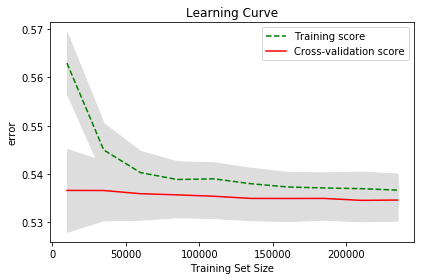

In [94]:
from sklearn import linear_model
from sklearn.model_selection import StratifiedKFold,learning_curve

skf = StratifiedKFold(n_splits=5)

# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(lr, 
                                                        Xs_train, 
                                                        ys_train,
                                                        cv= skf,
                                                        shuffle= True,
                                                        # Evaluation metric
                                                        scoring='f1',#f1
                                                        n_jobs=-1, 
                                                        train_sizes=list(range(10000, 259000, 25000)))

# Create means and standard deviations of training set scores
train_scores = abs(train_scores)
test_scores = abs(test_scores)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="g",  label="Training score")
plt.plot(train_sizes, test_mean, color="r", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("error"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

### Random Forest Classifier

In [95]:
start = time. time()

clf=RF(n_estimators=50, random_state = 42)


#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(pd.DataFrame(X_train[str_feature]), Y_train)

y_pred=clf.predict(pd.DataFrame(X_test[str_feature]))

end = time. time()
print("Time taken (hrs): ",(end - start)/3600)

Time taken (hrs):  0.03753868169254727


### RF model Accouracy 

In [96]:
# Model Accuracy, how often is the classifier correct?
errors = abs(y_pred - Y_test)
print("Random Forest Accuracy:",accuracy_score(Y_test, y_pred))

Random Forest Accuracy: 0.8177147792330363


## RF accuracy score for each Class Label

### Mean absolute Error for each Class Label

In [97]:
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.18 degrees.


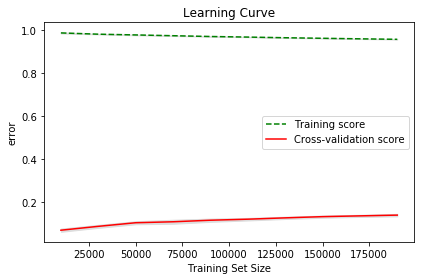

In [101]:
from sklearn import linear_model
from sklearn.model_selection import StratifiedKFold,learning_curve

skf = StratifiedKFold(n_splits=5)

# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(clf, 
                                                        pd.DataFrame(X_train[str_feature]), 
                                                        Y_train,
                                                        cv= skf,
                                                        shuffle= True,
                                                        # Evaluation metric
                                                        scoring='f1',#f1
                                                        n_jobs=-1, 
                                                        train_sizes=list(range(10000, 200000, 20000)))

# Create means and standard deviations of training set scores
train_scores = abs(train_scores)
test_scores = abs(test_scores)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="g",  label="Training score")
plt.plot(train_sizes, test_mean, color="r", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("error"), plt.legend(loc="best")
plt.tight_layout()
plt.show()